In [6]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import random

root_folder = r"C:\Users\Adeel\Desktop\Fyp\Fyp Dataset"
output_csv = os.path.join(root_folder, "ravdess_all_actors_full_features.csv")

emotion_map = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}

max_pad_len = 130  # Time frames
n_mfcc = 13
min_duration = 1.0  # Minimum duration in seconds

def augment_audio(y, sr):
    try:
        choice = random.choice(['pitch', 'stretch', 'noise', 'none'])
        if choice == 'pitch':
            y = librosa.effects.pitch_shift(y, sr=sr, n_steps=random.uniform(-2, 2))
        elif choice == 'stretch':
            rate = random.uniform(0.8, 1.2)
            y = librosa.effects.time_stretch(y, rate)
        elif choice == 'noise':
            noise = np.random.randn(len(y))
            y = y + 0.005 * noise
        return y
    except Exception as e:
        print(f"❌ Augmentation error: {e}")
        return y

def extract_info(filename):
    parts = filename.split("-")
    if len(parts) >= 7:
        emotion_code = parts[2]
        actor_id = int(parts[-1].split(".")[0])
        emotion = emotion_map.get(emotion_code, "unknown")
        empathy_label = 1 if emotion in ['calm', 'happy'] else 0
        return emotion, empathy_label, actor_id
    return "unknown", 0, -1

def extract_features(file_path, augment=False):
    try:
        y, sr = librosa.load(file_path, sr=16000)
        if len(y) < sr * min_duration:
            print(f"⚠️ Skipping {file_path}: too short ({len(y)/sr:.2f}s)")
            return np.zeros((max_pad_len, 28))
        if augment:
            y = augment_audio(y, sr)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        rmse = librosa.feature.rms(y=y)
        # Always ensure correct shape
        try:
            features = np.vstack([mfcc, chroma, spec_centroid, zcr, rmse])  # Shape: (28, time)
        except Exception as e:
            print(f"❌ Feature stacking error for {file_path}: {e}")
            return np.zeros((max_pad_len, 28))
        # Pad or truncate
        if features.shape[1] < max_pad_len:
            pad_width = max_pad_len - features.shape[1]
            features = np.pad(features, ((0, 0), (0, pad_width)), mode='constant')
        else:
            features = features[:, :max_pad_len]
        # Normalize features
        try:
            scaler = StandardScaler()
            features = scaler.fit_transform(features.T).T
        except Exception as e:
            print(f"❌ Scaling error for {file_path}: {e}")
            # If scaling fails, just return padded features
        return features.T  # Shape: (130, 28)
    except Exception as e:
        print(f"❌ Error extracting from {file_path}: {e}")
        return np.zeros((max_pad_len, 28))

# Main loop
data = []
error_files = []

for dirpath, _, files in os.walk(root_folder):
    for file in files:
        if file.endswith(".wav"):
            file_path = os.path.join(dirpath, file)
            try:
                features = extract_features(file_path, augment=True)  # shape (130, 28)
                emotion, empathy, actor_id = extract_info(file)
                flat_features = features.flatten()  # 130 × 28 = 3640
                row = {
                    "filename": file,
                    "actor_id": actor_id,
                    "emotion": emotion,
                    "empathy_label": empathy
                }
                for i, val in enumerate(flat_features):
                    row[f"feat_{i+1}"] = val
                data.append(row)
                print(f"✅ Processed {file} - Emotion: {emotion}")
            except Exception as e:
                print(f"❌ Error processing {file}: {e}")
                error_files.append(file_path)

# Balance emotions
if data:
    df = pd.DataFrame(data)
    emotion_counts = df['emotion'].value_counts()
    min_count = emotion_counts.min()
    balanced_df = pd.concat([df[df['emotion'] == emo].sample(n=min_count, random_state=42) for emo in emotion_counts.index])
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
    balanced_df.to_csv(output_csv, index=False)
    print(f"\n💾 Saved balanced feature dataset to: {output_csv}")
    print(f"Emotion counts after balancing:\n{balanced_df['emotion'].value_counts()}")
else:
    print("⚠️ No data extracted.")
if error_files:
    print(f"\n⚠️ Skipped/Errored files: {len(error_files)}")
    for ef in error_files:
        print(ef)

✅ Processed yt_audio.wav - Emotion: unknown
✅ Processed 03-01-01-01-01-01-01.wav - Emotion: neutral
✅ Processed 03-01-01-01-01-02-01.wav - Emotion: neutral
✅ Processed 03-01-01-01-02-01-01.wav - Emotion: neutral
✅ Processed 03-01-01-01-02-02-01.wav - Emotion: neutral
✅ Processed 03-01-02-01-01-01-01.wav - Emotion: calm
✅ Processed 03-01-02-01-01-02-01.wav - Emotion: calm
✅ Processed 03-01-01-01-02-02-01.wav - Emotion: neutral
✅ Processed 03-01-02-01-01-01-01.wav - Emotion: calm
✅ Processed 03-01-02-01-01-02-01.wav - Emotion: calm
✅ Processed 03-01-02-01-02-01-01.wav - Emotion: calm
✅ Processed 03-01-02-01-02-02-01.wav - Emotion: calm
✅ Processed 03-01-02-01-02-01-01.wav - Emotion: calm
✅ Processed 03-01-02-01-02-02-01.wav - Emotion: calm
✅ Processed 03-01-02-02-01-01-01.wav - Emotion: calm
✅ Processed 03-01-02-02-01-02-01.wav - Emotion: calm
❌ Augmentation error: time_stretch() takes 1 positional argument but 2 were given
✅ Processed 03-01-02-02-01-01-01.wav - Emotion: calm
✅ Processed

C:\Users\Adeel\AppData\Local\Temp\ipykernel_7432\977914804.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='emotion', data=df, palette='Set2', order=sorted(df['emotion'].unique()))


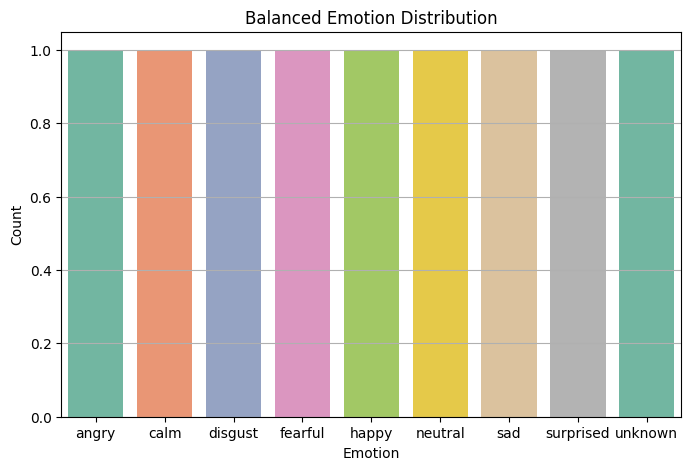

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv(r"C:\Users\Adeel\Desktop\Fyp\Fyp Dataset\ravdess_all_actors_full_features.csv")
plt.figure(figsize=(8,5))

sns.countplot(x='emotion', data=df, palette='Set2', order=sorted(df['emotion'].unique()))
plt.title('Balanced Emotion Distribution')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.grid(axis='y')
plt.show()

In [9]:
import os
import librosa
import numpy as np
import yt_dlp
import json
import speech_recognition as sr
import joblib # or just `import joblib` if using normal pip install
from moviepy.editor import VideoFileClip

# ---------------------------- Step 1: Download YouTube Audio ----------------------------
def download_youtube_audio(url, output_wav="yt_audio1.wav"):
    ydl_opts = {
        'format': 'bestaudio/best',
        'outtmpl': 'yt_audio.%(ext)s',
        'postprocessors': [{
            'key': 'FFmpegExtractAudio',
            'preferredcodec': 'wav',
            'preferredquality': '192',
        }],
    }

    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        ydl.download([url])
        print(f"✅ Downloaded and converted to {output_wav}")

# ---------------------------- Step 2: Transcribe Audio ----------------------------
def transcribe_audio(wav_file):
    r = sr.Recognizer()
    with sr.AudioFile(wav_file) as source:
        audio = r.record(source)
        text = r.recognize_google(audio)
    return text

# ---------------------------- Step 3: Extract MFCC & Predict Emotion ----------------------------
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=16000)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    return np.mean(mfcc.T, axis=0).reshape(1, -1)

def predict_emotion(model, encoder, features):
    prediction = model.predict(features)
    return encoder.inverse_transform(prediction)[0]

# ---------------------------- Step 4: Compute Empathy Score ----------------------------
def compute_empathy_score(audio_path):
    y, sr = librosa.load(audio_path)
    pitch = librosa.yin(y, fmin=75, fmax=300)
    pitch_var = np.var(pitch)
    energy = np.mean(librosa.feature.rms(y=y))
    empathy_score = round((pitch_var * 0.6 + energy * 0.4) * 100, 2)
    return empathy_score

# ---------------------------- Step 5: Main Pipeline ----------------------------
def run_pipeline(youtube_url):
    download_youtube_audio(youtube_url, "yt_audio.wav")

    transcription = transcribe_audio("yt_audio.wav")
    print("🗣️ Transcription:", transcription)

    features = extract_features("yt_audio.wav")

    # Load your trained model and encoder
    model = joblib.load("emotion_model.pkl")
    label_encoder = joblib.load("emotion_label_encoder.pkl")

    emotion = predict_emotion(model, label_encoder, features)
    print("🎭 Predicted Emotion:", emotion)

    empathy = compute_empathy_score("yt_audio.wav")
    print("💓 Empathy Score:", empathy)

    # Save to JSON
    result = {
        "youtube_url": youtube_url,
        "transcription": transcription,
        "emotion": emotion,
        "empathy_score": empathy
    }

    with open("session_scores.json", "w") as f:
        json.dump(result, f, indent=4)
    print("📄 Result saved to session_scores.json")

# ---------------------------- Run Example ----------------------------
# Replace with your actual YouTube video URL
run_pipeline("https://youtube.com/shorts/bUSh5oa-iuI?si=2BuJ8U3jBJ8XpRm2")


[youtube] Extracting URL: https://youtube.com/shorts/bUSh5oa-iuI?si=2BuJ8U3jBJ8XpRm2
[youtube] bUSh5oa-iuI: Downloading webpage
[youtube] bUSh5oa-iuI: Downloading tv client config
[youtube] bUSh5oa-iuI: Downloading tv player API JSON
[youtube] bUSh5oa-iuI: Downloading ios player API JSON
[youtube] bUSh5oa-iuI: Downloading m3u8 information
[info] bUSh5oa-iuI: Downloading 1 format(s): 251
[download] Destination: yt_audio.webm
[download] 100% of  539.83KiB in 00:00:02 at 193.72KiB/s 
[ExtractAudio] Destination: yt_audio.wav
Deleting original file yt_audio.webm (pass -k to keep)
✅ Downloaded and converted to yt_audio.wav
🗣️ Transcription: yes great your full name for me b a n s a l OK Google and struggling with the Hay Day for two days let's see thank you so much
🎭 Predicted Emotion: disgust
💓 Empathy Score: 227965.28
📄 Result saved to session_scores.json
